In [2]:
%run "! DEFAULT PLOT THINGIES.ipynb"
%run "../! DEFAULT PLOT THINGIES.ipynb"

import glob
import pandas as pd
import scipy.io
from hdf_tools.pytables_import_shear import load_measurement
from hdf_tools import getcc

from __future__ import division

<IPython.core.display.Javascript object>

Current working directory is now c:\users\deen\dropbox\phd rearrangements\thesis\notebooks\sven-trajectories
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<IPython.core.display.Javascript object>

Current working directory is now c:\users\deen\dropbox\phd rearrangements\thesis\notebooks\sven-trajectories
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
(
    notP,seed,step_num,
    cc_strained,cc_no,
    gamma_before,gamma_after,
    s_xy_strained_min,s_xy_strained_plus,
    U_strained_min,U_strained_plus,
    rsq,affinersq,
    Lxx,Lxy,Lyx,Lyy,
    ccr0,ccr1,ccr2,ccr3,
    num_cc_changed_r0,num_cc_changed_r1,num_cc_changed_r2,num_cc_changed_r3,
    COMx,COMy,
    prat,
    num01p,num05p,num10p,num15p,num20p,
    num01s,num05s,num10s,num15s,num20s,
    rad_gyr_01p,rad_gyr_05p,rad_gyr_10p,rad_gyr_15p,rad_gyr_20p,
    rad_gyr_01s,rad_gyr_05s,rad_gyr_10s,rad_gyr_15s,rad_gyr_20s,
    rad_hyd_01p,rad_hyd_05p,rad_hyd_10p,rad_hyd_15p,rad_hyd_20p,
    rad_hyd_01s,rad_hyd_05s,rad_hyd_10s,rad_hyd_15s,rad_hyd_20s,
    rad_gr_w,rad_hr_w,
    _,_,_
) = scipy.io.loadmat(r"F:\Leiden Data\Summarized\all_cc_all_data")['all_cc_times_512'].T

pressure = notP.copy()
pressure[notP>0.1] = (notP/1e3)[notP>0.1]

In [4]:
def load_alphalist(alphalist):
    # dan gaan we nu proberen de gekke datafiles in te lezen. We beginnen met alphalist_strain
    import ast

    sven_data = {'alpha': [], 'endstates': []}

    i = 0
    for line in open(alphalist):
        if line.startswith('a'):
            sven_data['alpha'].append(np.float64(line[25:].split(" ", 1)[0]))
            i += 1
        elif line.startswith('{'):
            data = ast.literal_eval(line)
            data["index"] = i
            sven_data['endstates'].append( data)
        else:
            pass
        
    sven_data['alpha'] = np.array(sven_data['alpha'])
    return sven_data

def get_event_alpha(alphalist, event):
    previous = {'index': 0}
    for i in alphalist['endstates']:
        if i['step#'] == event:
            break
        else:
            previous = i
    
    alphas = np.array(alphalist['alpha'][previous['index']:i["index"]])
    return alphas

def get_final_steps(alphas):
    fs = np.concatenate([np.where(np.diff(np.unique(alphas, return_inverse=True)[-1]) != 0)[0], [len(alphas)-1]])
    #fs = fs[fs > len(alphas)/2]
    return fs

def load_relaxation(wholepath, length, p0, p1):
    X = np.loadtxt(wholepath, usecols=[p0,p1])

    if length:
        X = X[-length:]
    
    return X[:,0] - X[:,1]



rearr_tresh_rsq = 1e-11
msk = (pressure == 1e-2) * (seed == 8005) #* (rsq > rearr_tresh_rsq)
print rsq[msk]
print np.sum(rsq[msk] > rearr_tresh_rsq)

rearrs = np.where(rsq[msk] > rearr_tresh_rsq)[0]
print rearrs

rmsk = msk * (rsq > rearr_tresh_rsq)
print step_num[rmsk]

In [5]:
path = r"F:\Leiden Data\P010e-1\8005"

alphalist_stress_file = glob.glob(path + "/alphalist_stress_*")[0]
alphalist_stress = load_alphalist(alphalist_stress_file)

alphalist_strain_file = glob.glob(path + "/alphalist_strain_*")[0]
alphalist_strain = load_alphalist(alphalist_strain_file)

def get_event_id(event):
    return int(event.split("_E")[1].split("_")[0])

events = sorted(glob.glob(path + "\*FIRE_stress*.txt"), key=get_event_id)
event_ids = [get_event_id(e) for e in events]

basename = os.path.split(glob.glob(path + "/log*step*.txt")[0])[1].split("log")[1]
comments, packings, log = load_measurement(path, basename)
packings = packings.to_records()

basepack = packings[0]
alpha0 = packings[0]['alpha']

497


\includegraphics{notebooks/sven-trajectories/trajectory.pdf}


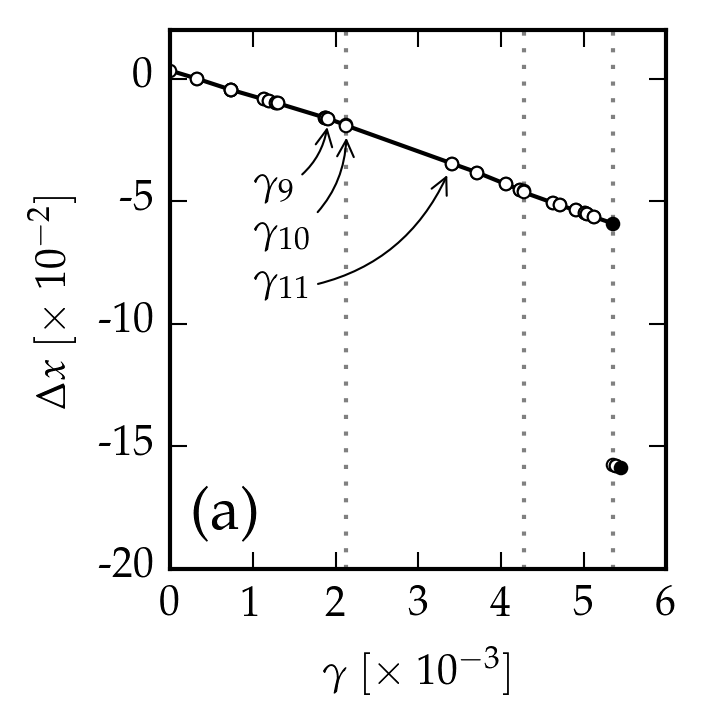

In [54]:
halffig()

#plt.subplot(1,2,1)

pa = 0; pb = 1
x0 = None

previous = None

strains = []
Xs = []

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)

    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = X-x0
    
    strains.append(gamma[-1])
    Xs.append(X[-1])
    
    if i in rearrs:
        plt.axvline(befores['gamma'][-1], ls=":", color='gray')

    if len(gamma) > 0:
        plt.plot(gamma, X, "k")
        plt.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
        plt.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]


plt.annotate(
    r"$\gamma_{9}$",
    (strains[9], Xs[9]),
    (1e-3,-5e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.3",
                   linewidth=0.5,
                   shrinkA=0),
)

plt.annotate(
    r"$\gamma_{10}$",
    (strains[10], Xs[10]),
    (1e-3,-7e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.3",
                   linewidth=0.5,
                   shrinkA=0, shrinkB=3),
)

plt.annotate(
    r"$\gamma_{11}$",
    (strains[11], Xs[11]),
    (1e-3,-9e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.3",
                   linewidth=0.5,
                   shrinkA=0, shrinkB=3),
)

plt.xlabel(r"$\gamma~[\times~10^{-3}]$")
plt.ylabel(r"$\Delta x~[\times~10^{-2}]$")

yt = np.arange(-0.2,0.01,0.05)
plt.yticks(yt, [int(np.round(y * 1e2,0)) for y in yt])

xt = np.arange(0, 0.0061, 0.001)
plt.xticks(xt, [int(x * 1e3) for x in xt])

subplotlabel('(a)', loc='lower left')
plt.savefig('trajectory.pdf')

\includegraphics{notebooks/sven-trajectories/trajectory-zoom.pdf}


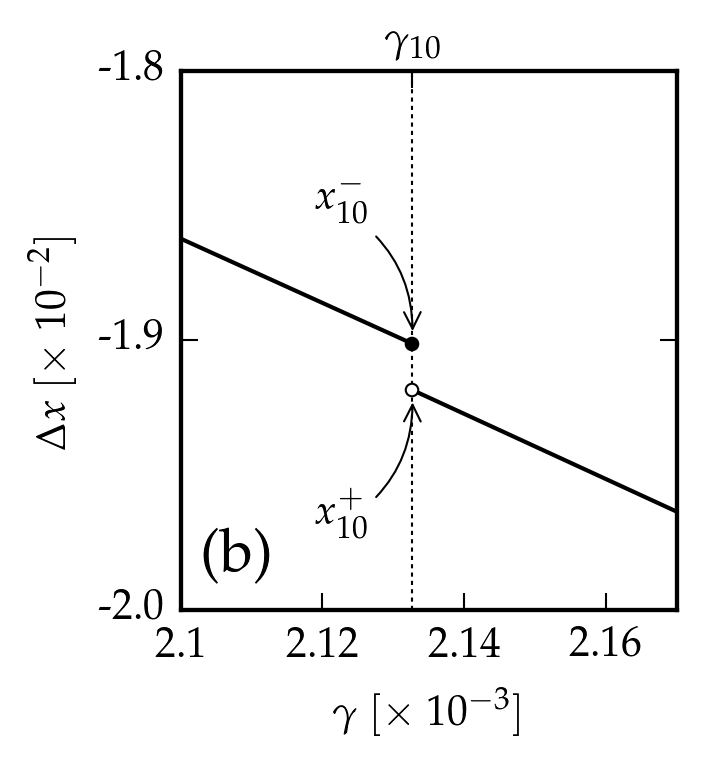

In [45]:
halffig()

pa = 0; pb = 1
x0 = None

previous = None

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #plt.axvline(befores['gamma'][-1], color='gray', lw=0.1)
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)
        
    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = X-x0
    
    if len(gamma) > 0:
        plt.plot(gamma, X, "k")
        plt.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
        if False and 150 < afters[0]['step#'] < 250:
            plt.text(gamma[0], X[0], str(afters[0]['step#']))
            print gamma[0], str(afters[0]['step#'])
        plt.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]
    
    if i == 10:
        ten_X_before = X[-1]
    if i == 11:
        ten_gamma = gamma[0]
        ten_X_after = X[0]
    
plt.axis(xmin=2.1e-3,xmax=2.17e-3,ymin=-0.02,ymax=-0.018)

plt.xlabel(r"$\gamma~[\times~10^{-3}]$")
plt.ylabel(r"$\Delta x~[\times~10^{-2}]$")

yt = np.arange(-0.02,-0.018,0.001)
plt.yticks(yt, [np.round(y * 1e2,3) for y in yt])

xt = np.arange(2.1e-3, 2.17e-3, 0.02e-3)
plt.xticks(xt, [np.round(x * 1e3,2) for x in xt])

plt.annotate(
    r"$x_{10}^-$",
    (ten_gamma, ten_X_before),
    (ten_gamma-0.01e-3,ten_X_before+0.05e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-0.3",
                   linewidth=0.5,
                   shrinkA=0, shrinkB=3),
    va='center', ha='center'
)

plt.annotate(
    r"$x_{10}^+$",
    (ten_gamma, ten_X_after),
    (ten_gamma-0.01e-3,ten_X_after-0.05e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.3",
                   linewidth=0.5,
                   shrinkA=0, shrinkB=3),
    va='center', ha='center'
)

plt.axvline(ten_gamma, dashes=(1,1), zorder=-3, color='black', lw=0.5)

ax = plt.axis()
plt.twiny()
plt.axis(ax)
plt.xticks([ten_gamma], [r"$\gamma_{10}$"])
plt.gca().xaxis.set_tick_params(pad=0)

subplotlabel('(b)', loc='lower left')
plt.savefig('trajectory-zoom.pdf')